"FC layers referenced from https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65"


In [84]:
import torch
import os
import numpy as np
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


In [2]:
class FCLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return x

class ActivationLayer(nn.Module):
    def __init__(self, activation_fn):
        super(ActivationLayer, self).__init__()
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(x)
        return x

def tanh(x):
    return torch.tanh(x)

def sigmoid(x):
    return torch.sigmoid(x)

class MyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyNetwork, self).__init__()
        self.fc1 = FCLayer(input_dim, hidden_dim)
        self.activation1 = ActivationLayer(tanh)
        self.fc2 = FCLayer(hidden_dim, output_dim)
        self.activation2 = ActivationLayer(sigmoid)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        return x

# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size


In [141]:
# loading files
checkFile = os.path.isfile("data/dump/train_labels.pkl")

if not checkFile:
    print("Please run the context_encoder notebook to save label file")
    
else:
    file = open('data/dump/train_labels.pkl', 'rb')
    y_train = pickle.load(file)
    y_train = torch.tensor(y_train)
    file.close()

In [142]:
# loading files 2
file_path = 'embed/updated_representation.pkl'

# Load the list from the file using pickle
with open(file_path, 'rb') as file:
    updated_representations = pickle.load(file)

    # Concatenate all the tensors representing individual utterances
    concatenated_tensors = []
    for dialogue_tensor in updated_representations:
        concatenated_tensors.extend(dialogue_tensor)

# Convert the concatenated list of tensors into a single tensor
tensor_utterances = torch.stack(concatenated_tensors)

checkFile = os.path.isfile("data/dump/1st_gat.pkl")
if not checkFile:
    print("Run relation-type encoder before running classifier")
    
else:
    file = open('data/dump/1st_gat.pkl', 'rb')
    cherry_picked_nodes, _ = pickle.load(file)
    file.close()

checkFile = os.path.isfile("data/dump/2nd_gat.pkl")
if not checkFile:
    print("Run relation-type encoder before running classifier")
    
else:
    file = open('data/dump/2nd_gat.pkl', 'rb')
    all_node_feats, _ = pickle.load(file)
    file.close()
    
_ = None
print(cherry_picked_nodes.shape, all_node_feats.shape)


torch.Size([12840, 300]) torch.Size([12840, 300])


EDA

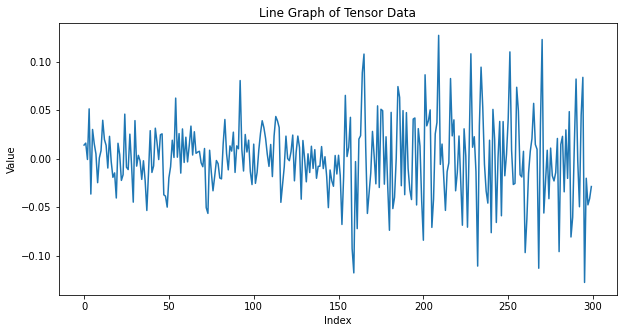

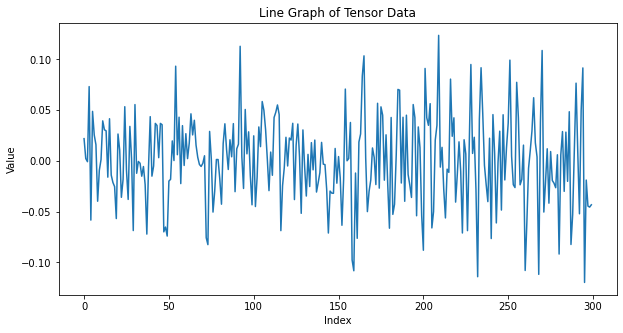

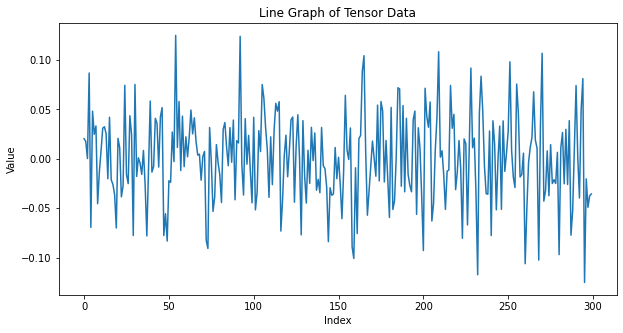

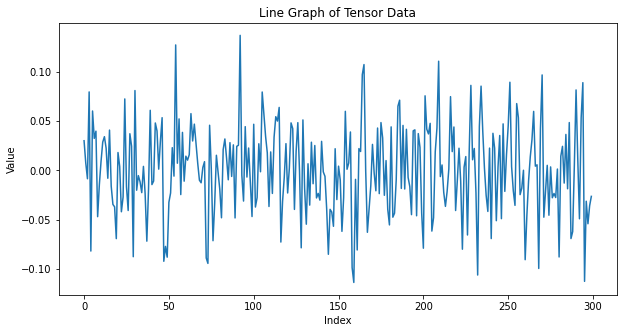

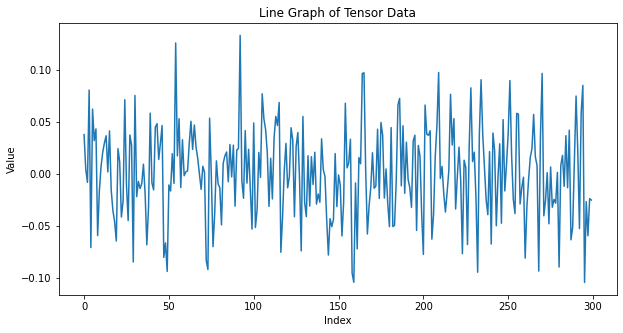

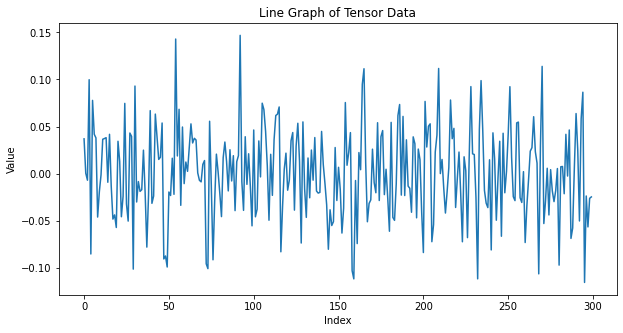

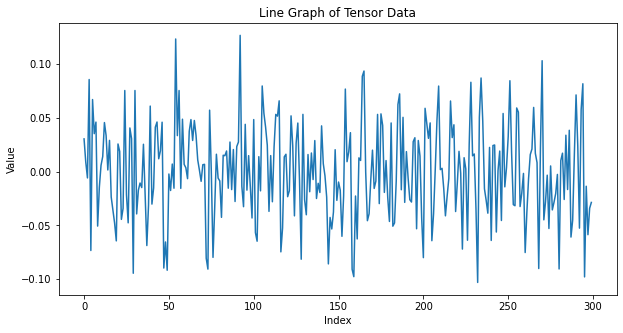

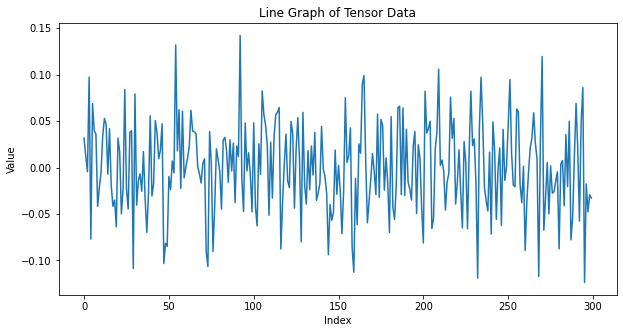

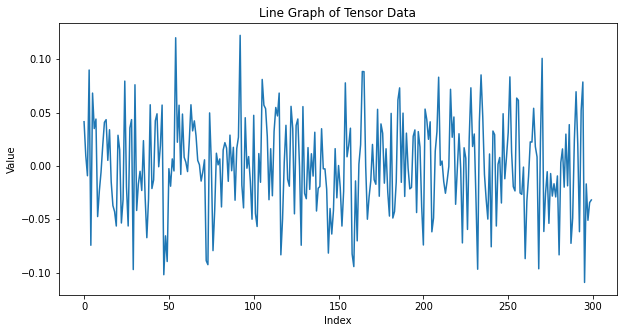

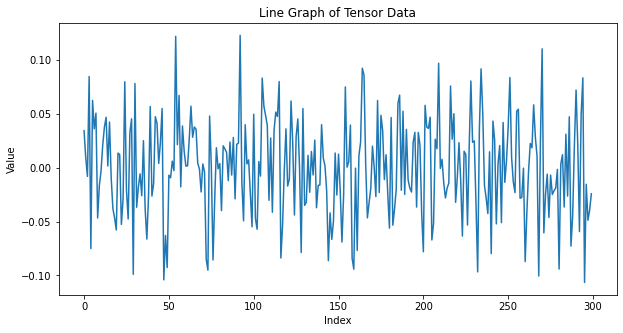

In [45]:
# Checking the structure of graph
for n in range(10):
    tensor_data_np = tensor_utterances[n].detach().numpy()

    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(tensor_data_np)), tensor_data_np)
    plt.title('Line Graph of Tensor Data')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()


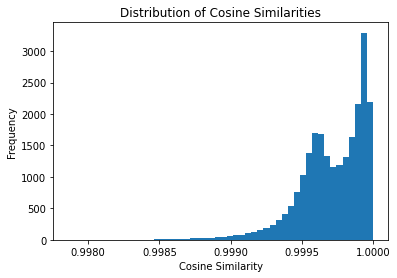

In [8]:
# Normalize the h' (1st GAT)
data = cherry_picked_nodes.detach().numpy()
data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)

# Compute pairwise cosine similarities
similarities = cosine_similarity(data_normalized)

# Print or analyze the similarity matrix
# print(similarities)
plt.hist(similarities.flatten(), bins=50, density=True)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


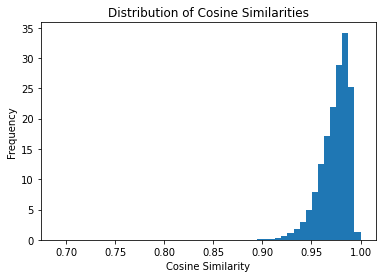

In [9]:
# Normalize the h' (2nd GAT)
data = all_node_feats.detach().numpy()
data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)

# Compute pairwise cosine similarities
similarities = cosine_similarity(data_normalized)

# Print or analyze the similarity matrix
# print(similarities)
plt.hist(similarities.flatten(), bins=50, density=True)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


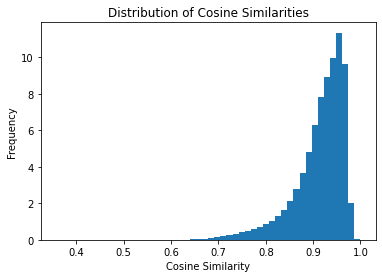

In [20]:
# Normalize the u' or updated_representations
data = tensor_utterances.detach().numpy()
data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)

# Compute pairwise cosine similarities
similarities = cosine_similarity(data_normalized)

plt.hist(similarities.flatten(), bins=50, density=True)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


Prep data and EDA


In [81]:
X_train = tensor_utterances

Part 1

In [65]:
# Define the number of features (k) to select
k = 100  # Adjust this value as needed

# Initialize SelectKBest with the desired score function (e.g., f_classif for classification tasks)
selector = SelectKBest(score_func=f_classif, k=k)

# Fit SelectKBest on the training data and target variable
selector.fit(X_train, Y_train)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the scores of the selected features
feature_scores = selector.scores_[selected_indices]

# Display the scores along with their corresponding indices
# for idx, score in zip(selected_indices, feature_scores):
#     print(f"Feature index: {idx}, Score: {score}")

X_train_selected = X_train[:, selected_indices]
print(X_train_selected.shape)

torch.Size([12840, 100])


In [76]:
file = open('data/dump/label_decoder.pkl', 'rb')
label_decoder = pickle.load(file)

Selected feature u'

In [144]:
# Apply Min-Max scaling to make the data non-negative
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(tensor_utterances)

# Now, you can proceed to fit SelectKBest on the scaled data
selector.fit(X_train_scaled, mask)
# Assuming X_train is your feature matrix (12840 instances x 300 dimensions)
# and y_train is your target labels

# Initialize a dictionary to store the indices of top features for each class
top_features_by_class = {}
top_scores = {}
# Calculate the relevance of each feature to each class using chi-squared test
for label in range(7):  # Assuming you have 7 classes
    # Create a binary mask indicating instances belonging to the current class
    mask = (Y_train == label)
    
    # SelectKBest with chi2 as the scoring function
    selector = SelectKBest(score_func=chi2, k=20)  # Select top 20 features
    selector.fit(X_train_scaled, mask)  # Fit SelectKBest to the data
    
    # Get the indices of the top 20 features
    top_features_indices = np.argsort(selector.scores_)[-20:]
    scores = selector.scores_[indices]
    # Store the indices in the dictionary
    top_features_by_class[label] = top_features_indices
    top_scores[label] = scores
    
# Print the top features for each class
for label, indices in top_features_by_class.items():
    print(f"Label {label_decoder[label]}: idx {', '.join(map(str, indices))}")
#     print(top_scores[label])

Label anger: idx 136, 172, 268, 15, 115, 114, 92, 79, 5, 30, 11, 39, 63, 48, 116, 54, 46, 29, 126, 73
Label fear: idx 207, 29, 201, 126, 209, 188, 39, 173, 131, 11, 54, 152, 235, 134, 266, 28, 268, 41, 88, 140
Label neutral: idx 114, 131, 42, 3, 18, 46, 156, 2, 32, 79, 39, 11, 134, 148, 202, 57, 116, 54, 140, 248
Label sadness: idx 140, 268, 279, 131, 34, 15, 63, 126, 42, 46, 127, 134, 54, 79, 73, 82, 70, 48, 11, 83
Label surprise: idx 279, 188, 82, 34, 152, 46, 207, 103, 126, 166, 79, 127, 48, 268, 73, 83, 15, 63, 172, 11
Label joy: idx 139, 47, 144, 70, 203, 12, 197, 46, 28, 39, 5, 48, 115, 54, 30, 116, 126, 29, 34, 73
Label disgust: idx 273, 63, 172, 186, 279, 54, 15, 127, 46, 83, 114, 208, 103, 126, 11, 202, 116, 79, 73, 48


In [145]:
concatenated_features_set = set()
for label, indices in top_features_by_class.items():
    concatenated_features_set.update(indices)

concatenated_features_indices = list(concatenated_features_set)


In [147]:
concatenated_features_indices = np.array(concatenated_features_indices)

# Select the desired features from X_train
selected_features = tensor_utterances[:, concatenated_features_indices]
print(selected_features.shape)

torch.Size([12840, 61])


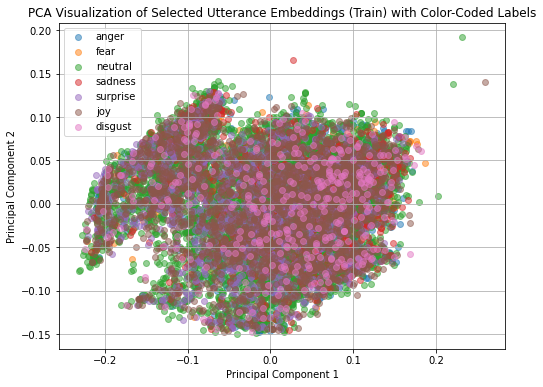

In [201]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(selected_features.detach().numpy())

# Plot the PCA result with color-coded labels
plt.figure(figsize=(8, 6))
for label in np.unique(Y_train):
    indices = Y_train == label
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'{label_decoder[label]}', alpha=0.5)
plt.title('PCA Visualization of Selected Utterance Embeddings (Train) with Color-Coded Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

Selected feature's GAT

current progress (9pm March 6)

In [ ]:
# Assuming cnn_bilstm_representations and gat_representations are PyTorch tensors
# concatenated_representation1 = torch.cat((tensor_utterances, cherry_picked_nodes), dim=1)
#  concatenated_representation2 = torch.cat((cherry_picked_nodes, all_node_feats), dim=1)
# print(concatenated_representation1.shape, concatenated_representation2.shape)

Training and predicting


In [199]:
print(selected_features.shape)
# Generate sample data
num_instances = len(selected_features)
input_dim = selected_features.shape[1]
num_classes = 7

X_train = selected_features
# X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
Y_train = y_train
# X_train = torch.randn(num_instances, input_dim)
# Assuming Y_train is a vector containing the label indices (0 to num_classes-1) for each instance
# Y_train = torch.randint(0, num_classes, (num_instances,))

# Calculate class weights to balance the loss function
class_counts = torch.bincount(Y_train)
class_weights = torch.tensor([0.15, 0.03, 0.15, 0.09, 0.15, 0.23, 0.04])

# Initialize the model
model = MyNetwork(input_dim, 30, num_classes)
print(model)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 3000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:  # Reduced printing frequency for faster training progress monitoring
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


torch.Size([12840, 61])
MyNetwork(
  (fc1): FCLayer(
    (fc): Linear(in_features=61, out_features=30, bias=True)
  )
  (activation1): ActivationLayer()
  (fc2): FCLayer(
    (fc): Linear(in_features=30, out_features=7, bias=True)
  )
  (activation2): ActivationLayer()
)
Epoch [100/3000], Loss: 1.9209
Epoch [200/3000], Loss: 1.8987
Epoch [300/3000], Loss: 1.8721
Epoch [400/3000], Loss: 1.8419
Epoch [500/3000], Loss: 1.8102
Epoch [600/3000], Loss: 1.7797
Epoch [700/3000], Loss: 1.7522
Epoch [800/3000], Loss: 1.7288
Epoch [900/3000], Loss: 1.7096
Epoch [1000/3000], Loss: 1.6942
Epoch [1100/3000], Loss: 1.6819
Epoch [1200/3000], Loss: 1.6722
Epoch [1300/3000], Loss: 1.6644
Epoch [1400/3000], Loss: 1.6581
Epoch [1500/3000], Loss: 1.6530
Epoch [1600/3000], Loss: 1.6489
Epoch [1700/3000], Loss: 1.6454
Epoch [1800/3000], Loss: 1.6425
Epoch [1900/3000], Loss: 1.6400
Epoch [2000/3000], Loss: 1.6379
Epoch [2100/3000], Loss: 1.6361
Epoch [2200/3000], Loss: 1.6346
Epoch [2300/3000], Loss: 1.6332
E

In [198]:
# Predict on the training data
with torch.no_grad():
    outputs = model(X_train)
    _, predicted = torch.max(outputs.data, 1)

# Calculate accuracy
accuracy = (predicted == Y_train).sum().item() / num_instances
print(f'Training Accuracy: {accuracy * 100:.2f}%')

unique_labels, label_counts = np.unique(predicted, return_counts=True)

# Print the counts for each unique label
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} occurrences")
print("------------------------")

unique_labels, label_counts = np.unique(Y_train, return_counts=True)

# Print the counts for each unique label
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} occurrences")


Training Accuracy: 18.01%
Label 5: 12840 occurrences
------------------------
Label 0: 1500 occurrences
Label 1: 338 occurrences
Label 2: 5960 occurrences
Label 3: 876 occurrences
Label 4: 1490 occurrences
Label 5: 2312 occurrences
Label 6: 364 occurrences


Creating dataloader

In [ ]:
# # sample
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import numpy as np

# # Define the size of the dataset and the number of classes
# num_samples = 1000
# num_classes = 3

# # Generate balanced labels
# labels = np.random.randint(0, num_classes, size=num_samples)

# # Create sample data features (random numbers)
# data = np.random.rand(num_samples, 300)

# # Convert data and labels to PyTorch tensors
# data_tensor = torch.tensor(data, dtype=torch.float32)
# labels_tensor = torch.tensor(labels, dtype=torch.long)

# # Define a custom PyTorch Dataset class
# class CustomDataset(Dataset):
#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return self.data[idx], self.labels[idx]

# # Create an instance of the custom dataset
# dataset = CustomDataset(data_tensor, labels_tensor)

# # Define batch size for DataLoader
# batch_size = 32

# # Create a PyTorch DataLoader
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Define a simple fully connected neural network
# class SimpleFC(nn.Module):
#     def __init__(self):
#         super(SimpleFC, self).__init__()
#         self.fc1 = nn.Linear(300, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, num_classes)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# # Create an instance of the model
# model = SimpleFC()

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)

#         # Compute loss
#         loss = criterion(outputs, labels)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         # Compute accuracy
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         if i % 100 == 99:
#             print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}, Accuracy: {100 * correct / total:.2f}%')
#             running_loss = 0.0

# print('Finished Training')


In [ ]:
# # Prediction\n",
# outputs = model(concatenated_representation1)
# _, predicted = torch.max(outputs, 1)
# precision, recall, fscore, support = precision_recall_fscore_support(y_train_tensor, predicted, zero_division=1)   

In [ ]:
# Assuming y_train is a numpy array of integer labels
y_train_tensor = torch.LongTensor(y_train)

# Create a TensorDataset
train_dataset1 = TensorDataset(concatenated_representation1, y_train_tensor)
train_dataset2 = TensorDataset(concatenated_representation2, y_train_tensor)

# Define batch size
batch_size = 64

# Create DataLoader
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)

In [ ]:
for range_pair in ranges:
    start_idx, end_idx = range_pair
    speaker_per_dialog = X_train[['Dialogue_ID','Speaker']][start_idx:end_idx+1].copy()
    speaker_feature = set(speaker_per_dialog["Speaker"])
    print(start_idx, end_idx ,speaker_feature)
    print(list(speaker_per_dialog["Dialogue_ID"]))
    speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
    speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}
